In [224]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
import joblib
from sklearn.metrics import mean_absolute_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

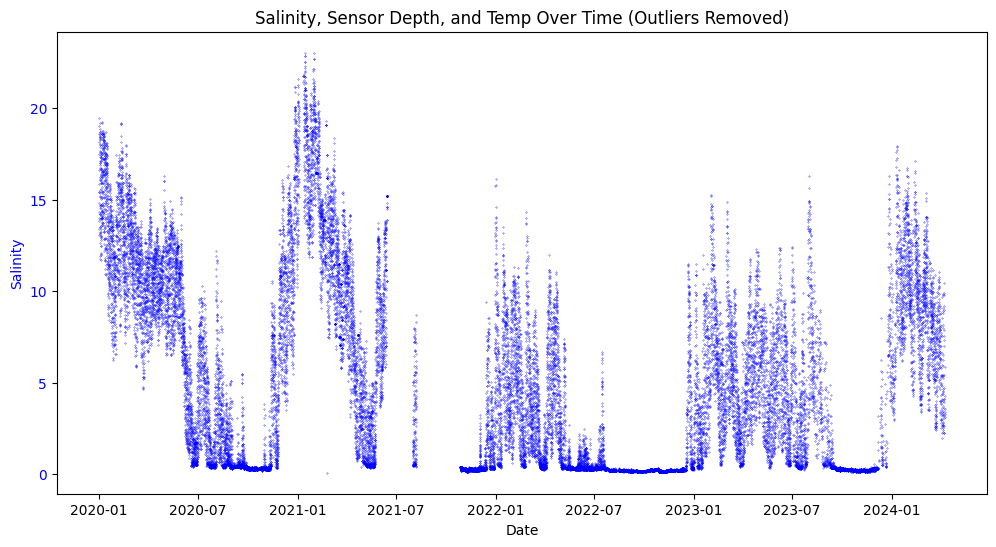

In [225]:
csv_path = '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/FALL/RND1/Data/cleaned_port_v2.csv'
df = pd.read_csv(csv_path)

# Convert date_time to datetime format and set as the index
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df.set_index('date_time', inplace=True)

# Filter for columns 'Salinity' and 'Sensor_Depth' and remove rows with NaN values
df = df.loc['2020-01-01':'2024-05-01', ['Salinity']].dropna()

# Remove outliers in Sensor_Depth (e.g., values below -10, assuming they're erroneous)
df = df[(df['Salinity'] > 0) & (df['Salinity'] < 50)]

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df.index, df['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Title and show plot
plt.title('Salinity, Sensor Depth, and Temp Over Time (Outliers Removed)')
plt.show()

In [226]:
# Load the preprocessing parameters
preprocessing_params = joblib.load('preprocessing_params.pkl')

# Extract the scaler and parameters
scaler = preprocessing_params['scaler']
train_mean = preprocessing_params['train_mean']
train_std = preprocessing_params['train_std']

In [227]:
normalized_df = np.log1p(df)

# Normalize the training set
normalized_df = (normalized_df - train_mean) / train_std  # Center data around 0 with unit variance

normalized_df = pd.DataFrame(normalized_df, columns=['Salinity'])

In [228]:
model = tf.keras.models.load_model('lstm_model64.keras')

In [229]:
# Make predictions
predictions = model.predict(normalized_df)

# Assuming 'df' has the true values in a column called 'Salinity'
true_values = df['Salinity'].values

934/934 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


In [230]:
# Assuming `predictions` has shape (batch_size, time_steps, features)
print(f"Predictions shape before reshaping: {predictions.shape}")

# Reshape predictions to 2D (merge batch_size and time_steps)
predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])

# Apply inverse transform (scaler expects 2D input)
denormalized_predictions = scaler.inverse_transform(predictions_reshaped)

# Reshape back to original 3D shape if necessary
denormalized_predictions = denormalized_predictions.reshape(predictions.shape)

print(f"Predictions shape after reshaping: {denormalized_predictions.shape}")
print(denormalized_predictions)

Predictions shape before reshaping: (29874, 1, 1)
Predictions shape after reshaping: (29874, 1, 1)
[[[49.964485]]

 [[49.835087]]

 [[49.466667]]

 ...

 [[38.86493 ]]

 [[41.072247]]

 [[43.685017]]]


In [231]:
# Import the MeanAbsoluteError class
mae_metric = tf.keras.losses.MeanAbsoluteError()

# Calculate MAE
mae = mae_metric(true_values, denormalized_predictions).numpy()
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 29.4204


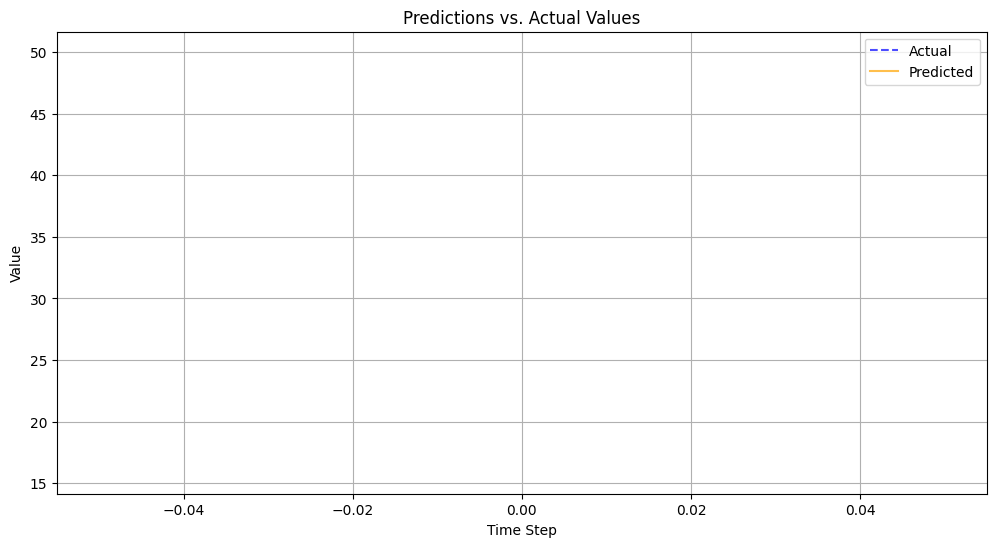

In [234]:
# Time steps from the denormalized predictions
time_steps = range(denormalized_predictions.shape[1])  # Number of time steps

plt.figure(figsize=(12, 6))

# Ensure labels are correctly indexed and match time_steps
plt.plot(time_steps, true_values[:len(time_steps)], label="Actual", linestyle='dashed', color='blue', alpha=0.7)

# Visualize the first sequence (batch index 0) from predictions
plt.plot(time_steps, denormalized_predictions[0, :, 0], label="Predicted", linestyle='solid', color='orange', alpha=0.7)

plt.title("Predictions vs. Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

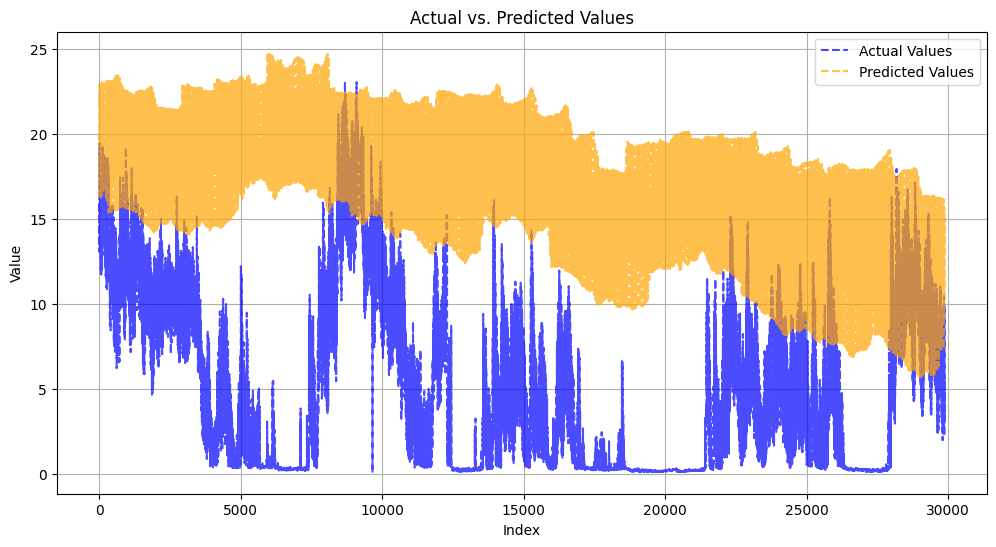

In [233]:
# Ensure labels and predictions are aligned in length
if len(labels) > len(flattened_predictions):
    labels = labels[:len(flattened_predictions)]
elif len(labels) < len(flattened_predictions):
    flattened_predictions = flattened_predictions[:len(labels)]

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(labels, label="Actual Values", linestyle="dashed", color="blue", alpha=0.7)
plt.plot(flattened_predictions, label="Predicted Values", linestyle="dashed", color="orange", alpha=0.7)

plt.title("Actual vs. Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()